# Credit Card Fraud

Kaggle Dataset  
https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud?datasetId=2156255&sortBy=voteCount

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, \
accuracy_score, classification_report, confusion_matrix

In [2]:
data = pd.read_csv('card_transdata.csv')
data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


Feature Explanation:

- distance_from_home - the distance from home where the transaction happened.
- distance_from_last_transaction - the distance from last transaction happened.
- ratio_to_median_purchase_price - Ratio of purchased price transaction to median purchase price.
- repeat_retailer - Is the transaction happened from same retailer.
- used_chip - Is the transaction through chip (credit card).
- used_pin_number - Is the transaction happened by using PIN number.
- online_order - Is the transaction an online order.
- fraud - Is the transaction fraudulent.

### Exploratory Data Analysis

Let's investigate a dataset.

In [3]:
# Dataframe size
data.shape

(1000000, 8)

As we can see, there's no missing values in data.

In [4]:
data.isna().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

Most of the columns are categorical except first three - we can use them to get more information about data.

In [5]:
data.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


To help with visualizations, we will take the log of few our features. Then to get a basic idea of continuous variables, let's make a pairplot.

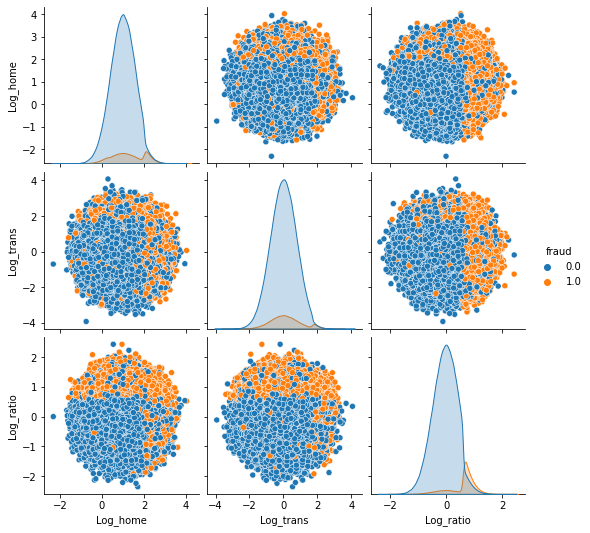

In [6]:
df = pd.DataFrame()
df['Log_home'] = np.log10(data['distance_from_home'])
df['Log_trans'] = np.log10(data['distance_from_last_transaction'])
df['Log_ratio'] = np.log10(data['ratio_to_median_purchase_price'])
df['fraud'] = data.fraud

sns.pairplot(data=df[['Log_home','Log_trans','Log_ratio','fraud']], hue = 'fraud')

An important thing to note is that the fraud data is bimodal, whereas the non fraud transaction data is unimodal. That will be a potential avenue to explore for feature engineering.

### Fraud and Non Fraud

Let's see how many fraud and non fraud transactions we have.

In [9]:
data.fraud.value_counts()

0.0    912597
1.0     87403
Name: fraud, dtype: int64

In [10]:
data.fraud.value_counts(normalize=True).mul(100)

0.0    91.2597
1.0     8.7403
Name: fraud, dtype: float64

OK, there are less then `10%` of fraud values in dataset. Not great, so it's better to bring the non-fraud transactions to the same amount as fraud transactions.  
NOW we will make a subsample which is more balanced dataset and thus avoiding our models to overfitting.

In [11]:
# Resample data with equally distributed Fraud Classes
fraud_df = data.loc[data['fraud'] == 1].sample(n = 87403, random_state = 42)
no_fraud_df = data.loc[data['fraud'] == 0].sample(n = 87403, random_state = 42)

In [12]:
# Make a new dataframe with shuffled values
new_df = pd.concat([fraud_df, no_fraud_df]).sample(frac=1, random_state=42)
new_df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
217828,3.133363,2.880819,15.609338,1.0,1.0,0.0,1.0,1.0
127305,0.919648,0.115513,4.307709,0.0,1.0,0.0,1.0,1.0
58084,15.161964,0.027713,0.914625,1.0,0.0,0.0,0.0,0.0
373205,3.294325,0.700697,1.829264,1.0,0.0,0.0,0.0,0.0
472229,76.742356,0.321263,0.177628,1.0,1.0,0.0,0.0,0.0


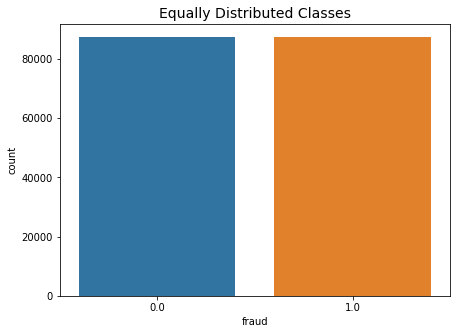

In [13]:
plt.figure(figsize=(7, 5))
sns.countplot(data=new_df, x='fraud')
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

As we can see now fraud and non fraud classes are distributed evenly.

### Corr Map

Now let's make a `correlation map`, maybe we'll already find some connections in data.  
We want to know if there are features that influence heavily in whether a specific transaction is a fraud. However, it is important that we use the correct dataframe (subsample) in order for us to see which features have a high positive or negative correlation with regards to fraud transactions.

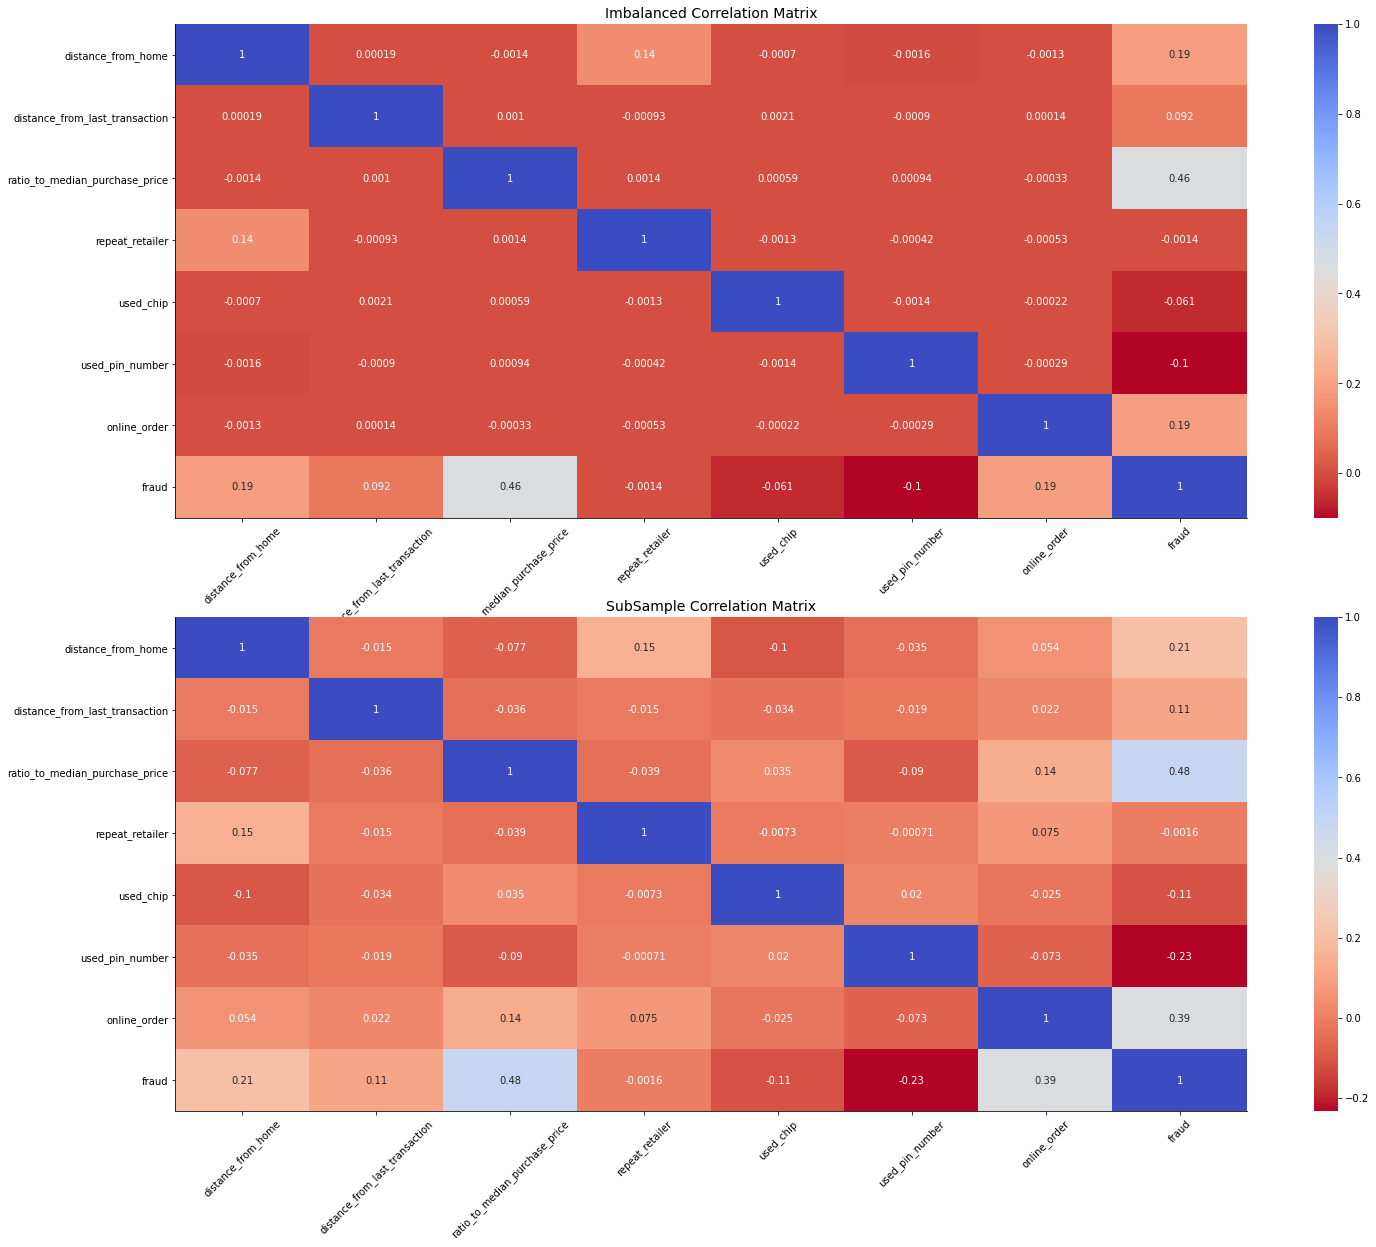

In [14]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))
# sns.set(rc={"figure.figsize": (15, 7)})

corr = data.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot=True, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix", fontsize=14)
ax1.set_xticklabels(corr.columns, rotation=45)

sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot=True, ax=ax2)
ax2.set_title('SubSample Correlation Matrix', fontsize=14)
ax2.set_xticklabels(corr.columns, rotation=45)

sns.despine()

As we can see discrete values have positive correlation with fraud class. Notice how the higher these values are, the more likely the end result will be a fraud transaction.

### Box plots

We will use boxplots to have a better understanding of the distribution of these features in fradulent and non fradulent transactions.  
There are too many outliers in data, and plots will be not so informative. We limit Y axes for a clearer picture.

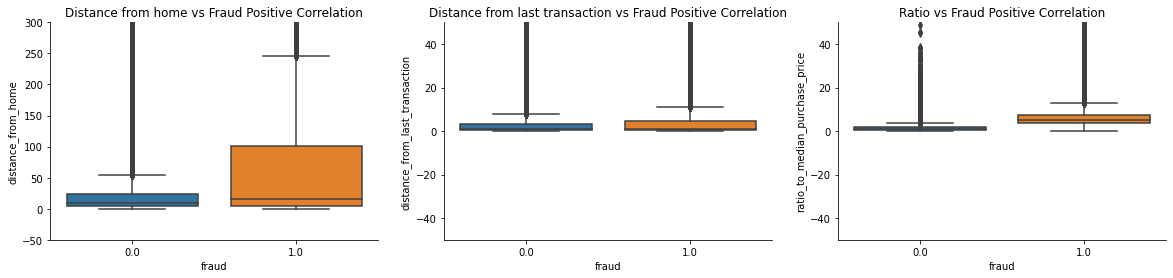

In [21]:
f, axes = plt.subplots(ncols=3, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(data=new_df, x='fraud', y='distance_from_home', ax=axes[0])
axes[0].set_title('Distance from home vs Fraud Positive Correlation')
axes[0].set_ylim(bottom=-50, top=300)

sns.boxplot(data=new_df, x='fraud', y='distance_from_last_transaction', ax=axes[1])
axes[1].set_title('Distance from last transaction vs Fraud Positive Correlation')
axes[1].set_ylim(bottom=-50, top=50)

sns.boxplot(data=new_df, x='fraud', y='ratio_to_median_purchase_price', ax=axes[2])
axes[2].set_title('Ratio vs Fraud Positive Correlation')
axes[2].set_ylim(bottom=-50, top=50)

sns.despine()

Outliers can significantly distort the ML model. But they also need to be removed with care.  
In this case, we will not remove outliers, due to simplicity of solution, but in general it would be worthwhile to tackle this task.

#### Creating a train and test samples

In [22]:
X = new_df.drop('fraud', axis=1)
y = new_df['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

We are ready to implement ML algorithms. We will use two of them: Decision Trees and Logistic Regression, due to theirs simplicity in model understanding.

### Decision Tree Classifier

In [24]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

Decision trees are quite simple and computate very fast. This desicion tree ran nearly instantly.

In [25]:
precision_score(y_test, y_pred)

0.9998848456932289

In [26]:
dt.score(X_test, y_test)

0.999942795034609

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     17596
         1.0       1.00      1.00      1.00     17366

    accuracy                           1.00     34962
   macro avg       1.00      1.00      1.00     34962
weighted avg       1.00      1.00      1.00     34962



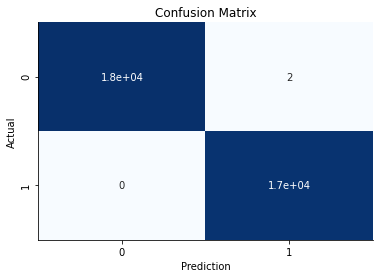

In [31]:
c_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(c_matrix, annot=True, cbar=False, cmap='Blues')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
ax.set_title('Confusion Matrix')

sns.despine()

As you can see, our model nearly perfectly classifies the test set.

### Logistic Regression Classifier

In [32]:
lr = LogisticRegression(solver='liblinear')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [33]:
precision_score(y_test, y_pred)

0.9293270312851677

In [34]:
lr.score(X_test, y_test)

0.9397631714432813

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94     17596
         1.0       0.93      0.95      0.94     17366

    accuracy                           0.94     34962
   macro avg       0.94      0.94      0.94     34962
weighted avg       0.94      0.94      0.94     34962



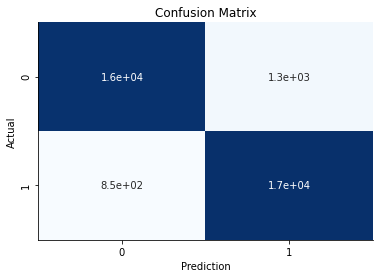

In [36]:
c_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(c_matrix, annot=True, cbar=False, cmap='Blues')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
ax.set_title('Confusion Matrix')

sns.despine()

Sadly, the result of logistic regression is much worse than DT. We get `850` false positives, `1 300` false negatives, `16 000` true negatives, and `17 000` true positives. 

### Confusion Matrix:
Positive/Negative: Type of Class (label) ["No", "Yes"] True/False: Correctly or Incorrectly classified by the model.

True Negatives (Top-Left Square): This is the number of correctly classifications of the "No" (No Fraud Detected) class.

False Negatives (Top-Right Square): This is the number of incorrectly classifications of the "No"(No Fraud Detected) class.

False Positives (Bottom-Left Square): This is the number of incorrectly classifications of the "Yes" (Fraud Detected) class

True Positives (Bottom-Right Square): This is the number of correctly classifications of the "Yes" (Fraud Detected) class.

### A Deeper Look into ROC

#### Terms:
- __True Positives__: Correctly Classified Fraud Transactions
- __False Positives__: Incorrectly Classified Fraud Transactions
- __True Negative__: Correctly Classified Non-Fraud Transactions
- __False Negative__: Incorrectly Classified Non-Fraud Transactions
- __Precision__: True Positives/(True Positives + False Positives)
- __Recall__: True Positives/(True Positives + False Negatives)
- Precision as the name says, says how precise (how sure) is our model in detecting fraud transactions while recall is the amount of fraud cases our model is able to detect.
- __Precision/Recall Tradeoff__: The more precise (selective) our model is, the less cases it will detect. Example: Assuming that our model has a precision of 95%, Let's say there are only 5 fraud cases in which the model is 95% precise or more that these are fraud cases. Then let's say there are 5 more cases that our model considers 90% to be a fraud case, if we lower the precision there are more cases that our model will be able to detect.

In [68]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict

log_reg_pred = cross_val_predict(lr, X_train, y_train, cv=5, method="decision_function")
tree_pred = cross_val_predict(dt, X_train, y_train, cv=5)

In [69]:
roc_auc_score(y_train, log_reg_pred), roc_auc_score(y_train, tree_pred)

(0.9793112508409848, 0.9999212819053633)

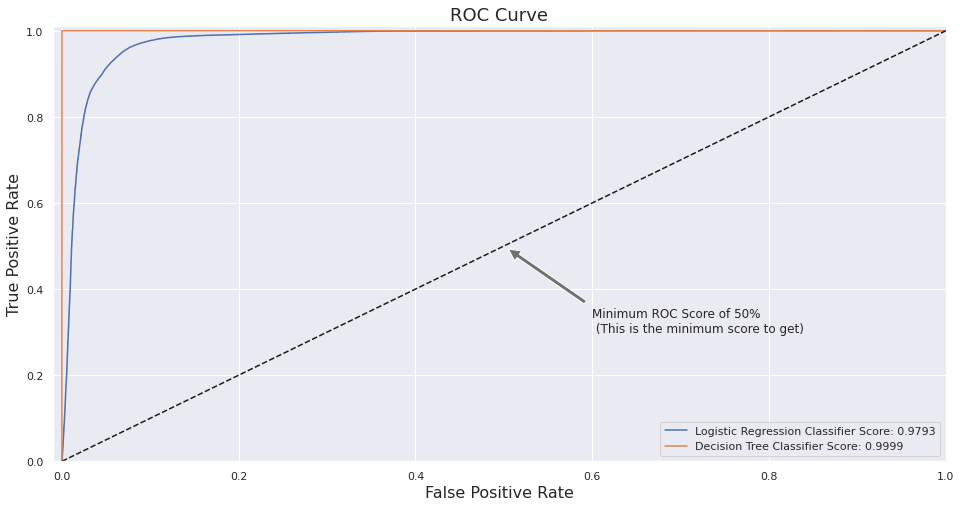

In [73]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)

def graph_roc_curve_multiple(log_fpr, log_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1.01])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, tree_fpr, tree_tpr)
plt.show()

__Summary__:  
- Precision of `LR` starts to descend 'till 0.95 nevertheless, its precision score is still ok and still we have a descent recall score.  
- `DT` precision is pretty high, it's almost hit `1`, which is great and we can definitely use this model to predict fraud transactions.

### Conclusion

We showed that fraud transactions will have different distributions than non fraud transactions in terms of quantitive data. We can use this fact to do feature engineering to give our models a leg up on classifying transactions as fraud.

Finally, we found that in this case a decision tree is most preferred model to use. It did not overfit, was computationally fast, and classified the test set nearly perfectly.